In [118]:
import pandas as pd
from matplotlib import pyplot as plt, ticker
plt.style.use("minimal")

FIGURE_SIZE = (5, 3.5)
ALPHABET = "abcdefghijklmnopqrstuvwzyz"

In [85]:
def load_data():
    global results
    results = pd.read_csv("results.csv")
    results["response_time"] *= 1000

load_data()
results.sample(5)

,session,trial,timestamp,cursor_position,response_time,target_response,response,feedback
176,2,1,2024-02-18 12:04:09.248328,146,75.8920,space,space,positive
472,2,2,2024-02-18 12:04:58.059075,144,130.9688,t,t,positive
354,2,2,2024-02-18 12:04:36.087157,41,60.6332,e,e,positive
1276,3,2,2024-02-18 14:11:13.773442,148,35.2677,s,s,positive
1075,3,1,2024-02-18 14:10:41.074328,213,78.6105,e,e,positive


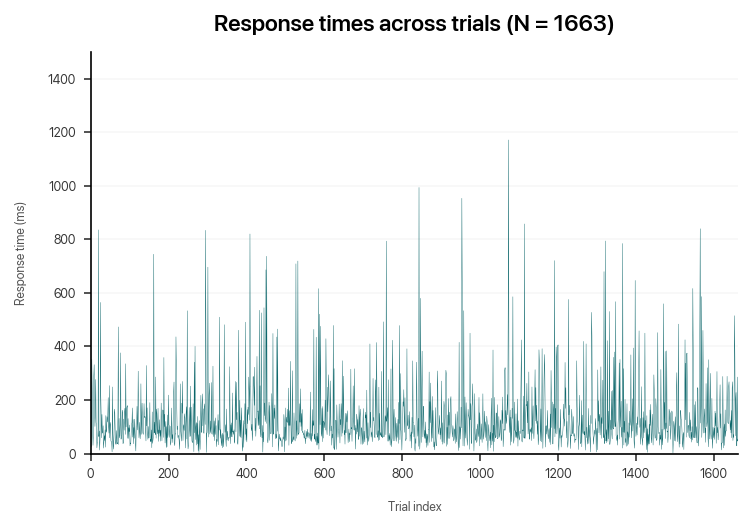

In [137]:
load_data()
plt.figure(figsize=FIGURE_SIZE)
subset = results.sample(min(len(results), 2000)).sort_index()
plt.plot(
    subset.index, 
    subset["response_time"],
    linewidth = 0.2,
)
plt.title(f"Response times across trials (N = {len(results)})")
plt.xlabel("Trial index")
plt.ylabel("Response time (ms)")
plt.ylim((0, 1500))
plt.tight_layout()

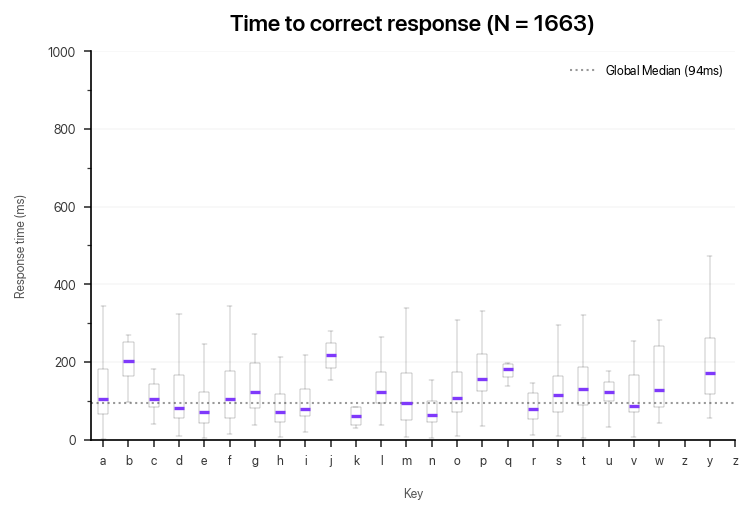

In [136]:
load_data()
plt.figure(figsize=FIGURE_SIZE)
time_to_type = results.groupby(["session", "trial", "cursor_position", "target_response"])["response_time"].sum().reset_index()

for key, data in time_to_type[time_to_type["target_response"].isin(list(ALPHABET))].groupby("target_response"):
    outlines_alpha = 0.5
    plt.boxplot(
        data["response_time"],
        positions=[ord(key)],
        widths = 0.4,
        boxprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        whiskerprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        capprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        flierprops = dict(marker = "o", markersize = 1, alpha = outlines_alpha, markeredgecolor = "none"),
        medianprops = dict(linewidth = 1.6, color = "C2"),
    )
plt.axhline(
    y = time_to_type["response_time"].median(),
    linestyle = ":",
    linewidth = 1,
    color = "black",
    alpha = 0.4,
    zorder = -1,
    label = f"""Global Median (${time_to_type["response_time"].median():.0f}$ms)"""
)
plt.legend(loc = "upper right")
plt.suptitle("")
plt.title(f"Time to correct response (N = {len(results)})")
plt.xlabel("Key")
plt.ylabel("Response time (ms)")
plt.xticks(range(97, 97 + 26), ALPHABET)
plt.yticks(range(0, 1000, 100))
plt.ylim((0, 1000))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(200))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(100))
plt.tight_layout()

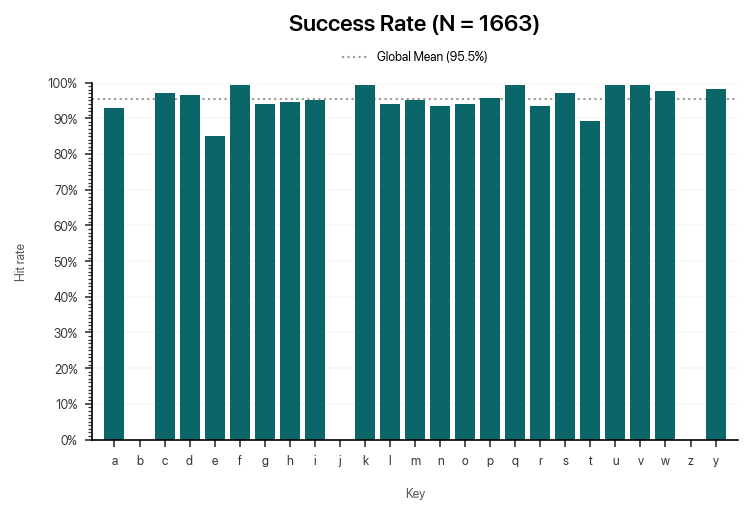

In [135]:
load_data()
plt.figure(figsize=FIGURE_SIZE)
incorrectly_typed = results[(results["response"].isin(list(ALPHABET.lower()))) & (results["response"] != results["target_response"])]
succes_rates = 1 - incorrectly_typed["response"].value_counts(normalize = True)

plt.bar(
    succes_rates.index.to_series().apply(ord), 
    succes_rates,
)

plt.axhline(
    y = succes_rates.mean(),
    linestyle = ":",
    linewidth = 1,
    color = "black",
    alpha = 0.4,
    zorder = -1,
    label = f"""Global Mean ({succes_rates.mean():.1%})"""
)
plt.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.12))
plt.title(f"Success Rate (N = {len(results)})", pad = 25)
plt.suptitle("")
plt.xlabel("Key")
plt.ylabel("Hit rate")
plt.xticks(range(97, 97 + 26), ALPHABET)
plt.margins(x = 0.02)
plt.ylim((0, 1))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
plt.tight_layout()

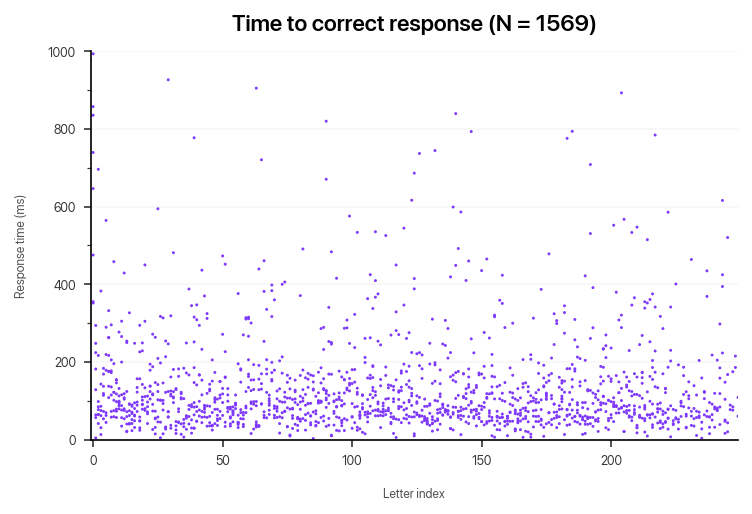

In [132]:
load_data()
plt.figure(figsize=FIGURE_SIZE)
plt.scatter(
    time_to_type["cursor_position"], 
    time_to_type["response_time"],
    marker = "o",
    s = 2,
    color = "C2",
    edgecolor = "none",
)
plt.suptitle("")
plt.title(f"Time to correct response (N = {len(time_to_type)})")
plt.xlabel("Letter index")
plt.ylabel("Response time (ms)")
plt.yticks(range(0, 1000, 100))
plt.ylim((0, 1000))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(200))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(100))
plt.tight_layout()